In [1]:
import os
import json
import kaggle.api
import zipfile # to extract data from zip archive
import pandas as pd
import numpy as np

from fastai.vision.all import *
from fastai.tabular.all import *
import torch

In [2]:
os.getcwd()

'/jet/prs/workspace/Kaggle_Rossman_Store_Sales'

In [3]:
path = Path('kaggle')

In [4]:
path

Path('kaggle')

In [5]:
tables = ['store', 'test', 'train']

In [6]:
df_store, df_test, df_train = [pd.read_csv(path/f'{name}.csv') for name in tables]

/jet/var/python/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3263: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [7]:
df_store.head(5)

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [8]:
df_train.head(3)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1


In [9]:
df_test.head(1)

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0


In [10]:
len(set(df_store.Promo2SinceWeek.values[~df_store.Promo2SinceWeek.isna()]))

24

### Simple approach

In [11]:
train_df = df_train.merge(df_store, on='Store')

In [12]:
train_df.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [13]:
cat_vars = ['DayOfWeek', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
             'CompetitionOpenSinceYear', 'Promo2','Promo2SinceYear', 'PromoInterval']
cont_vars = ['CompetitionDistance']

dep_var = 'Sales'

In [14]:
train_df[cat_vars]

,DayOfWeek,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionOpenSinceYear,Promo2,Promo2SinceYear,PromoInterval
0,5,1,1,0,1,c,a,2008.0,0,NaN,NaN
1,4,1,1,0,1,c,a,2008.0,0,NaN,NaN
2,3,1,1,0,1,c,a,2008.0,0,NaN,NaN
3,2,1,1,0,1,c,a,2008.0,0,NaN,NaN
4,1,1,1,0,1,c,a,2008.0,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
1017204,6,1,0,0,1,d,c,NaN,1,2012.0,"Mar,Jun,Sept,Dec"
1017205,5,1,0,0,1,d,c,NaN,1,2012.0,"Mar,Jun,Sept,Dec"
1017206,4,1,0,0,1,d,c,NaN,1,2012.0,"Mar,Jun,Sept,Dec"
1017207,3,1,0,0,1,d,c,NaN,1,2012.0,"Mar,Jun,Sept,Dec"


In [15]:
train_df[dep_var].min()

0

In [16]:
train_df[dep_var] = train_df[dep_var]+1    # add 1 to smooth the result of log (log(0)= -inf)

In [17]:
train_df[dep_var] = np.log(train_df[dep_var])  

In [18]:
train_df.Date = pd.to_datetime(train_df['Date'])

In [19]:
train_df.Date.max(), train_df.Date.min(), len(train_df)

(Timestamp('2015-07-31 00:00:00'), Timestamp('2013-01-01 00:00:00'), 1017209)

In [33]:
len(train_df), sum(train_df.Date.dt.year<2015)

(1017209, 780829)

In [20]:
# take the half of dataset for example learning
part_train = train_df[train_df.Date.dt.year<2014]; len(part_train)

406974

In [21]:
y_max_log = df_train[dep_var].max()*1.3; y_max_log

54016.3

In [22]:
y_range = torch.tensor([0,y_max_log])

In [23]:
procs = [FillMissing, Normalize, Categorify] 

In [24]:
#splits = (L(range(len(df_test), len(train))), L(range(len(df_test))))
splits = (L(range(len(df_test), len(part_train))), L(range(len(df_test))))

In [ ]:
####################

In [56]:
to=TabularPandas(part_train, procs, cat_vars, cont_vars, dep_var, y_block=RegressionBlock(), splits=splits)

In [152]:
??TabularPandas

In [57]:
dls = to.dataloaders(bs=512)

In [92]:
learn = tabular_learner(dls, layers=[1000,500], ps=[0.001,0.01], embed_p=0.04, y_range=y_range, 
                        metrics=exp_rmspe)

In [95]:
learn.summary()

TabularModel (Input shape: ['512 x 12', '512 x 1'])
Layer (type)         Output Shape         Param #    Trainable 
Embedding            512 x 5              40         True      
________________________________________________________________
Embedding            512 x 3              9          True      
________________________________________________________________
Embedding            512 x 3              9          True      
________________________________________________________________
Embedding            512 x 4              20         True      
________________________________________________________________
Embedding            512 x 3              9          True      
________________________________________________________________
Embedding            512 x 4              20         True      
________________________________________________________________
Embedding            512 x 3              12         True      
______________________________________________

SuggestedLRs(lr_min=0.33113112449646, lr_steep=0.0004786300996784121)

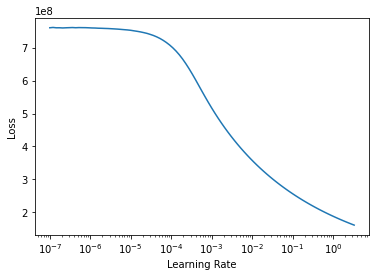

In [69]:
learn.lr_find()

In [93]:
learn.fit_one_cycle(5,1e-4) # if there is inf in the _exp_rmspe  -- it is normal< in the furthe learning cycles there will be
                            # a numbers (in the beginninth the loss in this metric is too big)

epoch,train_loss,valid_loss,_exp_rmspe,time
0,262157.250000,120435.835938,inf,00:32
1,1273.995605,751.289978,inf,00:32
2,20.843502,10.257405,5969.090332,00:32
3,9.988363,4.528609,90.959198,00:32
4,8.644956,2.960898,52.720863,00:32


In [94]:
learn.fit_one_cycle(5,1e-4)

epoch,train_loss,valid_loss,_exp_rmspe,time
0,7.591552,1.736916,16.632927,00:32
1,4.048055,6.499751,2.933047,00:32
2,0.944012,0.557731,1.548409,00:32
3,0.422758,0.185458,0.576126,00:32
4,0.353401,0.132292,0.413516,00:32


In [96]:
learn.fit_one_cycle(5,1e-4)

epoch,train_loss,valid_loss,_exp_rmspe,time
0,0.517764,0.979562,2.600419,00:32
1,0.406172,0.294834,0.415411,00:31
2,0.278868,0.394767,1.108449,00:32
3,0.206158,0.190589,0.646920,00:31
4,0.157879,0.095590,0.362155,00:31


In [99]:
learn.fit_one_cycle(5,1e-5)

epoch,train_loss,valid_loss,_exp_rmspe,time
0,0.126975,0.112404,0.426014,00:31
1,0.137804,0.109863,0.433538,00:31
2,0.124045,0.108548,0.422784,00:31
3,0.120625,0.105015,0.416575,00:31
4,0.114323,0.100066,0.398109,00:31


### 2) Feature Engineering (more carefull approach)

In [25]:
train_1 = part_train.copy()

In [26]:
# lets work with part_train dataset to reduce the training time
train_1.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
577,1,2,2013-12-31,7.767687,298,1,0,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
578,1,1,2013-12-30,8.881003,796,1,0,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
579,1,7,2013-12-29,0.000000,0,0,0,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
580,1,6,2013-12-28,8.641179,716,1,0,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
581,1,5,2013-12-27,8.717846,737,1,0,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN


In [27]:
part_train

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
577,1,2,2013-12-31,7.767687,298,1,0,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
578,1,1,2013-12-30,8.881003,796,1,0,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
579,1,7,2013-12-29,0.000000,0,0,0,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
580,1,6,2013-12-28,8.641179,716,1,0,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
581,1,5,2013-12-27,8.717846,737,1,0,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1115,6,2013-01-05,8.470521,339,1,0,0,1,d,c,5350.0,NaN,NaN,1,22.0,2012.0,"Mar,Jun,Sept,Dec"
1017205,1115,5,2013-01-04,8.420903,326,1,0,0,1,d,c,5350.0,NaN,NaN,1,22.0,2012.0,"Mar,Jun,Sept,Dec"
1017206,1115,4,2013-01-03,8.365905,300,1,0,0,1,d,c,5350.0,NaN,NaN,1,22.0,2012.0,"Mar,Jun,Sept,Dec"
1017207,1115,3,2013-01-02,8.215547,305,1,0,0,1,d,c,5350.0,NaN,NaN,1,22.0,2012.0,"Mar,Jun,Sept,Dec"


### fill NaN

In [28]:
train_1["Promo2SinceWeek"] = train_1.Promo2SinceWeek.fillna(0).astype(np.int32)
train_1["Promo2SinceYear"] = train_1.Promo2SinceYear.fillna(0).astype(np.int32)
train_1["CompetitionOpenSinceMonth"] = train_1.CompetitionOpenSinceMonth.fillna(0).astype(np.int32)
train_1["CompetitionOpenSinceYear"] = train_1.CompetitionOpenSinceYear.fillna(0).astype(np.int32)

In [29]:
sum(train_1["Promo"].isna()), sum(train_1["Promo2"].isna())

(0, 0)

In [30]:
train_1["PromoInterval"] = train_1.PromoInterval.fillna("N")

### Extract from Date all attributes

In [36]:
attr = ['Year', 'Month','Week', 'Day', 'Dayofweek', 'Dayofyear', 'Weekday', 'Quarter', 'Is_month_start', 'Is_month_end']

In [37]:
for i in attr:
    name = 'Date'
    train_1[name+i] = getattr(train_1[name].dt,i.lower())

/jet/var/python/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [38]:
train_1.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,...,DateYear,DateMonth,DateWeek,DateDay,DateDayofweek,DateDayofyear,DateWeekday,DateQuarter,DateIs_month_start,DateIs_month_end
577,1,2,2013-12-31,7.767687,298,1,0,0,1,c,...,2013,12,1,31,1,365,1,4,False,True
578,1,1,2013-12-30,8.881003,796,1,0,0,1,c,...,2013,12,1,30,0,364,0,4,False,False
579,1,7,2013-12-29,0.000000,0,0,0,0,1,c,...,2013,12,52,29,6,363,6,4,False,False
580,1,6,2013-12-28,8.641179,716,1,0,0,1,c,...,2013,12,52,28,5,362,5,4,False,False
581,1,5,2013-12-27,8.717846,737,1,0,0,1,c,...,2013,12,52,27,4,361,4,4,False,False


### TabularPandas and dataloaders

Note: experiment has shown that attributes ['Weekday', 'Quarter', 'Is_month_start', 'Is_month_end'] reduce the accuracy

In [55]:
cat_vars = ['Store', 'DayOfWeek', 'Promo', 'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
             'CompetitionOpenSinceYear', 'Promo2','Promo2SinceYear', 'PromoInterval', 'DateYear', 'DateMonth',
             'DateDay']

cont_vars = ['CompetitionDistance', 'Open']

dep_var = 'Sales'

In [56]:
y_max_log = train_1[dep_var].max()*1.3; y_max_log
y_range = torch.tensor([0,y_max_log])
procs = [FillMissing, Normalize, Categorify] 

In [57]:
y_max_log

13.709833039850391

In [58]:
splits = (L(range(len(df_test), len(part_train))), L(range(len(df_test))))

In [59]:
to = TabularPandas(train_1, procs, cat_vars, cont_vars, dep_var, y_block=RegressionBlock(), splits=splits)

In [60]:
dls = to.dataloaders(bs=64)

In [61]:
splits

((#365886) [41088,41089,41090,41091,41092,41093,41094,41095,41096,41097...],
 (#41088) [0,1,2,3,4,5,6,7,8,9...])

In [62]:
dls.show_batch()

,Store,DayOfWeek,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionOpenSinceYear,Promo2,Promo2SinceYear,PromoInterval,DateYear,DateMonth,DateDay,CompetitionDistance_na,CompetitionDistance,Open,Sales
0,318,6,0,0,0,d,c,2014,0,0,N,2013,4,13,False,32329.999315,1.000000e+00,8.474286
1,896,4,1,0,1,a,c,2012,0,0,N,2013,8,1,False,170.000117,1.000000e+00,9.113499
2,713,1,0,0,1,a,c,0,1,2014,"Jan,Apr,Jul,Oct",2013,10,28,False,219.999951,1.000000e+00,8.706491
3,715,7,0,0,0,a,a,2014,0,0,N,2013,6,30,False,14810.000044,3.820567e-08,0.000000
4,715,3,0,0,1,a,a,2014,0,0,N,2013,1,2,False,14810.000044,1.000000e+00,8.704668
5,422,4,0,0,1,a,c,0,0,0,N,2013,1,3,False,2880.000072,1.000000e+00,8.202209
6,323,7,0,0,0,d,c,2012,1,2013,"Feb,May,Aug,Nov",2013,10,27,False,8400.000104,3.820567e-08,0.000000
7,128,4,1,0,0,d,c,0,1,2013,"Jan,Apr,Jul,Oct",2013,11,21,False,1999.999994,1.000000e+00,8.914088
8,169,7,0,0,0,d,a,2014,1,2014,"Feb,May,Aug,Nov",2013,7,7,False,979.999790,3.820567e-08,0.000000
9,1004,1,1,0,0,d,c,0,1,2011,"Mar,Jun,Sept,Dec",2013,10,7,False,970.000187,1.000000e+00,8.948586


### Model

In [63]:
learn = tabular_learner(dls, layers=[1000,500], ps=[0.4,0.2], embed_p=0.2, y_range=y_range, 
                        metrics=exp_rmspe, loss_func=MSELossFlat())

In [64]:
learn.summary()

TabularModel (Input shape: ['64 x 15', '64 x 2'])
Layer (type)         Output Shape         Param #    Trainable 
Embedding            64 x 77              77,308     True      
________________________________________________________________
Embedding            64 x 5               40         True      
________________________________________________________________
Embedding            64 x 3               9          True      
________________________________________________________________
Embedding            64 x 4               20         True      
________________________________________________________________
Embedding            64 x 3               9          True      
________________________________________________________________
Embedding            64 x 4               20         True      
________________________________________________________________
Embedding            64 x 3               12         True      
________________________________________________

SuggestedLRs(lr_min=0.00043651582673192023, lr_steep=1.0964781722577754e-06)

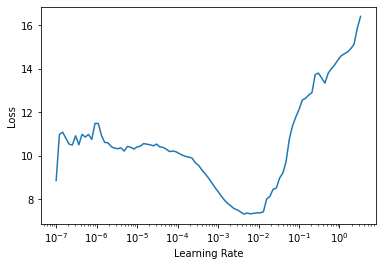

In [65]:
learn.lr_find()

In [66]:
learn.fit_one_cycle(5,lr=1e-3)

epoch,train_loss,valid_loss,_exp_rmspe,time
0,0.023371,0.077459,0.329415,02:31
1,0.013086,0.073526,0.298929,02:51
2,0.010934,0.075262,0.277901,02:47
3,0.012808,0.075219,0.283594,02:43
4,0.016420,0.075170,0.284972,02:47


In [69]:
learn = tabular_learner(dls, layers=[1000,500], ps=[0.4,0.2], embed_p=0.4, y_range=y_range, 
                        metrics=exp_rmspe)

SuggestedLRs(lr_min=0.002290867641568184, lr_steep=6.309573450380412e-07)

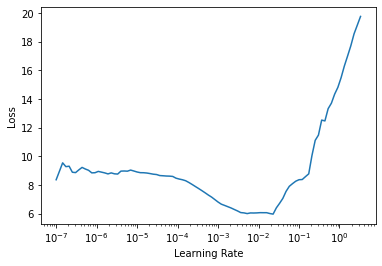

In [70]:
learn.lr_find()

In [71]:
learn.fit_one_cycle(5,lr=1e-2)

epoch,train_loss,valid_loss,_exp_rmspe,time
0,0.129138,0.203630,76.516754,02:49
1,0.128784,0.269492,65.553566,02:57
2,0.130334,0.229349,62.060505,03:20
3,0.076514,0.279592,59.624676,03:40
4,0.081356,0.300709,58.329830,03:43


SuggestedLRs(lr_min=4.365158383734525e-06, lr_steep=0.00013182566908653826)

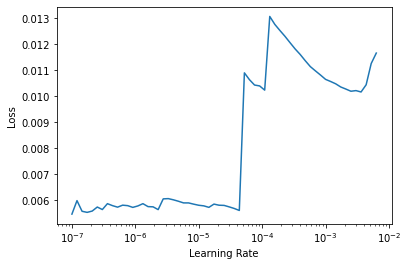

In [255]:
learn.lr_find()

In [257]:
learn.fit_one_cycle(5,lr=1e-5)

epoch,train_loss,valid_loss,_exp_rmspe,time
0,0.010609,0.073252,0.283858,00:37
1,0.011905,0.074996,0.296483,00:37
2,0.013362,0.075326,0.296850,00:37
3,0.006697,0.075399,0.301804,00:39
4,0.008306,0.075284,0.300287,00:38
